# Lecture 6 - Data-Driven Analysis Using DynamicalSystems.jl

- Last week we saw how to model a dynamical system with a known dynamic rule using DynamicalSystems.jl. We also saw how to calculate various dynamical properties of such a system, for example, Lyapunov exponents.
<br>

- This week we will turn our attention to data-driven analysis using DynamicalSystems.jl. In other words, **we suppose that we observe some system without necessarily knowing the dynamic rule in advance**.
<br>

- More often than not, what we observe in real life isn't the entire phase, in which the dynamics unfold, but rather some projection of the state onto a lower dimensional space. That is why our discussion of data-driven algorithms will focus in particular on phase space reconstruction using coordinates embedding, as you saw in this part of the lecture.


## Contents

1. [Delay Coordinates Embedding](#embedding)
2. [Choosing the Optimal Delay Time](#time)
3. [Choosing the Optimal Embedding Dimension](#dimension)
4. [Putting It All Together](#together)
5. [Lyapunov Exponents](#lyapunov)
6. [Further Reading](#further-reading)

In [ ]:
using Pkg
Pkg.activate(; temp = true)
Pkg.add("DynamicalSystems")
Pkg.add("NearestNeighbors")
Pkg.add("CairoMakie")

In [27]:
using DynamicalSystems, NearestNeighbors, CairoMakie

## 1. Delay Coordinates Embedding <a class="anchor" id="embedding"></a>

- Recall from the first part of the lecture that a scalar timeseries $s(t)$ can be embedded in a space of dimension $m$ via a time-delay embedding of the form $(s(t), s(t - \tau), s(t - 2\tau), \ldots, s(t - (m-1)\tau))$.
<br>

- To demonstrate delay coordinates embedding using DynamicalSystems.jl, we will "observe" the Lorenz system with a scalar measurement function $h : \mathbb{R}^3 \to \mathbb{R}$, such that our observation consists of a one-dimensional timeseries $s(t) = h(\mathbf{u}(t))$.
<br>

- For simplicity, we will take $s(t) = h(\mathbf{u}(t)) = x(t)$, that is, we observe only the $x$-coordinate. If the three dimensions of the Lorenz system correspond roughly to the rate of convection and the horizontal and vertical temperature variations, respectively, then this is like saying that we observe only the rate of convection.

In [28]:
h(u) = u[:, 1]  # Measurement function

h (generic function with 1 method)

In [29]:
# Generate synthetic data
ds = Systems.lorenz()
T = 100.0
Δt = 0.01
u = trajectory(ds, T; Ttr = 100.0, Δt)[1]

3-dimensional StateSpaceSet{Float64} with 10001 points
 -3.7179      -5.7157    15.8661
 -3.92754     -6.12402   15.6718
 -4.15752     -6.56215   15.5124
 -4.4088      -7.0316    15.3914
 -4.68242     -7.53367   15.313
 -4.97939     -8.06928   15.2819
 -5.30072     -8.6389    15.3035
 -5.64732     -9.24233   15.3837
 -6.01995     -9.8785    15.5292
 -6.41916    -10.5453    15.7474
 -6.84519    -11.2392    16.0459
 -7.29781    -11.955     16.433
 -7.77626    -12.6856    16.9172
  ⋮                      
 -0.135969     0.759574  19.4923
 -0.0515589    0.743953  18.9787
  0.0236733    0.735365  18.4792
  0.0912654    0.733721  17.9934
  0.152601     0.738926  17.5208
  0.208923     0.750904  17.0611
  0.261351     0.769607  16.6139
  0.310895     0.795034  16.1789
  0.35847      0.827235  15.7559
  0.404915     0.866321  15.3444
  0.450999     0.912468  14.9444
  0.49744      0.965928  14.5556

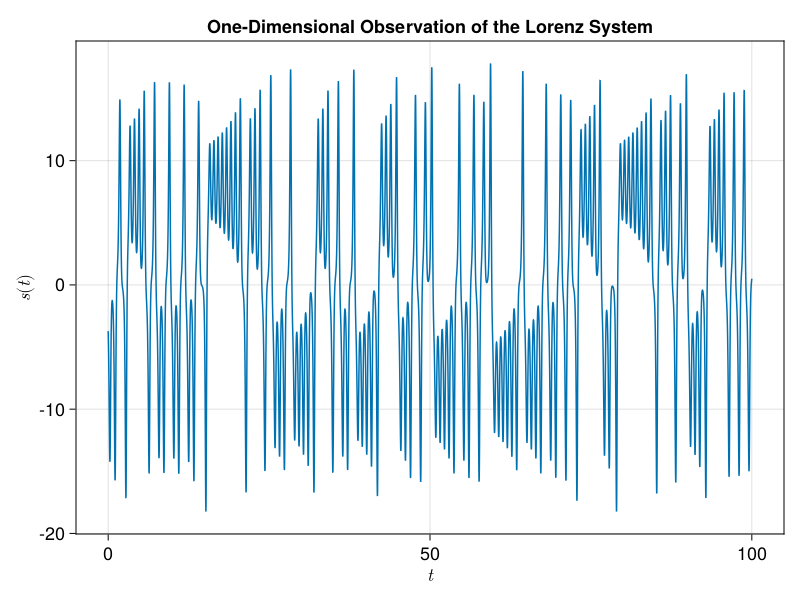

In [30]:
# "Measure" s(t) = h(u(t)) = x(t)
s = h(u)
fig = Figure(fontsize = 18)
ax = Axis(fig[1, 1], xlabel = L"t", ylabel = L"s(t)", title = "One-Dimensional Observation of the Lorenz System")
lines!(ax, 0:Δt:T, s)
fig

- To embed a one-dimensional timeseries $s(t)$ with embedding dimension $d$ and delay time $\tau \Delta t$, just do `embed(s, d, τ)` ([docs](https://juliadynamics.github.io/DynamicalSystemsDocs.jl/delayembeddings/stable/embed/#DelayEmbeddings.embed)).

In [31]:
d = 3
τ = 4
embed(s, d, τ)

3-dimensional StateSpaceSet{Float64} with 9993 points
 -3.7179     -4.68242     -6.01995
 -3.92754    -4.97939     -6.41916
 -4.15752    -5.30072     -6.84519
 -4.4088     -5.64732     -7.29781
 -4.68242    -6.01995     -7.77626
 -4.97939    -6.41916     -8.27904
 -5.30072    -6.84519     -8.80377
 -5.64732    -7.29781     -9.34698
 -6.01995    -7.77626     -9.90397
 -6.41916    -8.27904    -10.4686
 -6.84519    -8.80377    -11.0333
 -7.29781    -9.34698    -11.5887
 -7.77626    -9.90397    -12.1241
  ⋮                      
 -1.38731    -0.60239     -0.135969
 -1.15163    -0.462288    -0.0515589
 -0.944262   -0.339344     0.0236733
 -0.762148   -0.231267     0.0912654
 -0.60239    -0.135969     0.152601
 -0.462288   -0.0515589    0.208923
 -0.339344    0.0236733    0.261351
 -0.231267    0.0912654    0.310895
 -0.135969    0.152601     0.35847
 -0.0515589   0.208923     0.404915
  0.0236733   0.261351     0.450999
  0.0912654   0.310895     0.49744

- Let's plot the embedded attractor for a range of different delays $\tau$ and a fixed embedding dimension of 3.

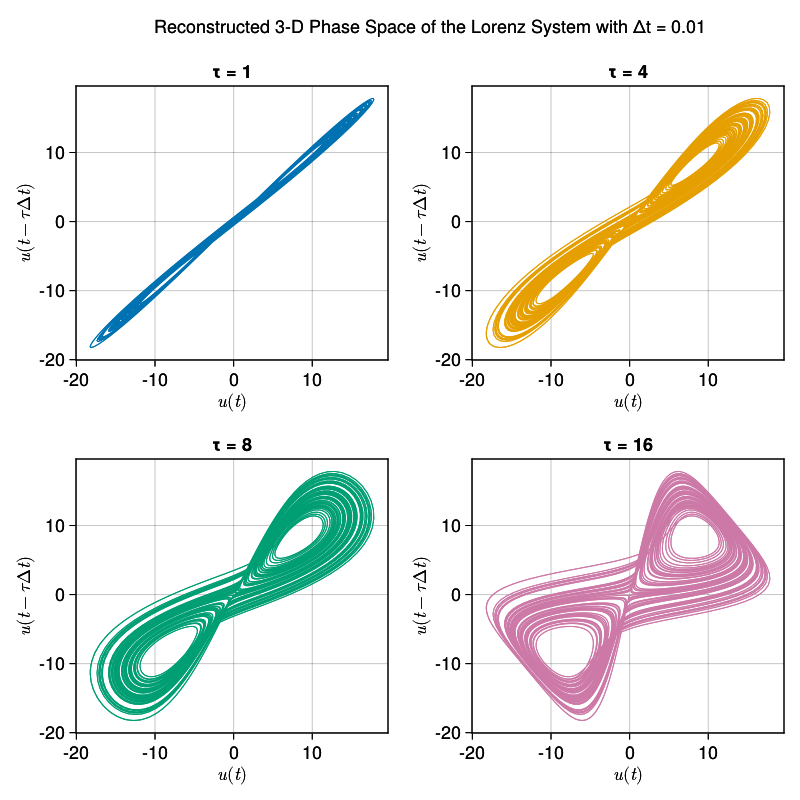

In [35]:
fig = Figure(resolution = (800, 800), fontsize = 18)
axes = [Axis(fig[1, 1]), Axis(fig[1, 2]), Axis(fig[2, 1]), Axis(fig[2, 2])]

for (i, τ) in enumerate([1, 4, 8, 16])
    data_embedded = embed(s, 3, τ)
    ax = axes[i]
    ax.title = "τ = $τ"
    ax.xlabel = L"u(t)"
    ax.ylabel = L"u(t-\tau \Delta t)"
    lines!(ax, data_embedded[:, 1], data_embedded[:, 2], color = Cycled(i), linewidth=1.0)
end

Label(fig[0, :], "Reconstructed 3-D Phase Space of the Lorenz System with Δt = $Δt")
fig

## 2. Choosing the Optimal Delay Time <a class="anchor" id="time"></a>

- Since no theorem exists guaranteeing an optimal choice of the delay time $\tau$, we must rely instead on a  **prescriptive approach**.
<br>

- As you saw in the first part of the lecture, two possibilities include using the **autocorrelation** and the **self mutual information** of the observed timeseries.
<br>

- Given the lack of an optimal method, it is especially important that we develop an intuitive understanding of the different approaches that are possible.
<br>

- Fortunately, while DynamicalSystems.jl provides useful high-level methods for estimating optimal time delays, it also exposes their low-level counterparts, permitting a more detailed and hands-on analysis.

### 2.1. Autocorrelation

- DynamicalSystems.jl uses the method `autocor` from the [StatsBase.jl](https://juliastats.org/StatsBase.jl/stable/) package for computing autocorrelations.
<br>

- It takes a one-dimensional timeseries as the first argument and an `AbstractVector` of lags as the second argument, returning a `Vector` of autocorrelations, one for each lag provided.

In [36]:
lags = 0:10
autocor(s, lags)

11-element Vector{Float64}:
 1.0
 0.9985108910549232
 0.9940841557996589
 0.9867783706196134
 0.9766893466167909
 0.9639474264561524
 0.9487138912258385
 0.9311766499010837
 0.9115454097467508
 0.8900465373528843
 0.8669178178163724

- Let's plot the autocorrelation of our scalar Lorenz timeseries for various different lags.

In [37]:
function plot_autocor(s, lags)
    fig = Figure(fontsize = 18)
    ax = Axis(
        fig[1, 1], 
        xlabel = L"\tau",
        xticks = 0:100:500,
        xminorticks = IntervalsBetween(2), 
        xminorticksvisible = true,
        xminorgridvisible = true,
        ylabel = "Autocorrelation", 
    )
    scatter!(ax, autocor(s, lags))
    return fig
end

plot_autocor (generic function with 1 method)

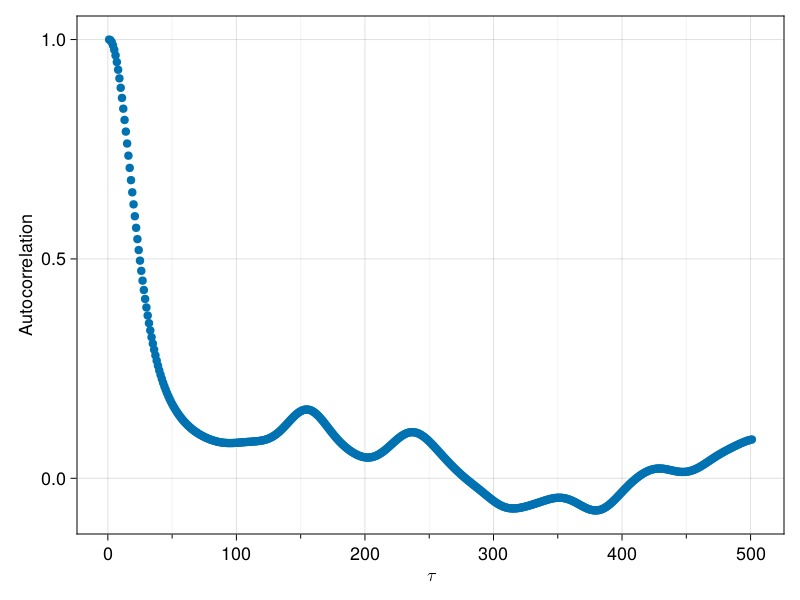

In [38]:
lags = 0:500
plot_autocor(s, lags)

- It looks like the first minimum occurs somewhere around $\tau = 100$, while the zero-crossing time is very long indeed, around $\tau = 275$.
<br>

- Sometimes, especially when embedding in higher dimensions, **relying on the crossing time of the autocorrelation can lead to very long delays**. 
<br>

- Another alternative is to choose as a delay the time taken for the autocorrelation function to decay to $1/e$ of its initial value. DynamicalSystems.jl provides the method `exponential_decay_fit(x, y)` which performs a least squares fit of the form $y = \exp(\frac{x}{\tau})$ and returns $\tau$.

In [39]:
x = 10:40  # You must choose the lags such that the autocorrelation remains positive
y = autocor(s, x)
exponential_decay_fit(x, y)

22.492472833686456

- Based on the autocorrelation, we already have three quite different estimates for the optimal delay, based on the first minimum, zero crossing time, and exponential decay.

### 2.2. Average Mutual Information

- As you learned earlier, a useful and often more robust alternative to autocorrelation is the average mutual information of the timeseries with itself at a given delay.
<br>

- DynamicalSystems.jl implements the method `selfmutualinfo(s, lags)` ([docs](https://juliadynamics.github.io/DynamicalSystemsDocs.jl/delayembeddings/stable/separated/#DelayEmbeddings.selfmutualinfo)).

In [40]:
lags = 0:10
selfmutualinfo(s, lags)

11-element Vector{Float64}:
 4.574512232569759
 3.520096917731454
 3.0227761714250865
 2.679065555578686
 2.4287663469708693
 2.227579971065682
 2.0554380648586634
 1.9093230043053635
 1.7841499237965759
 1.682156600173887
 1.5867427652376396

In [41]:
function plot_selfmutualinfo(s, lags)
    fig = Figure(fontsize = 18)
    ax = Axis(
        fig[1, 1], 
        xlabel = L"\tau", 
        xminorticks = IntervalsBetween(5), 
        xminorticksvisible = true,
        xminorgridvisible = true,  
        ylabel = "Self Mutual Information", 
    )
    scatter!(ax, selfmutualinfo(s, lags))
    return fig
end

plot_selfmutualinfo (generic function with 1 method)

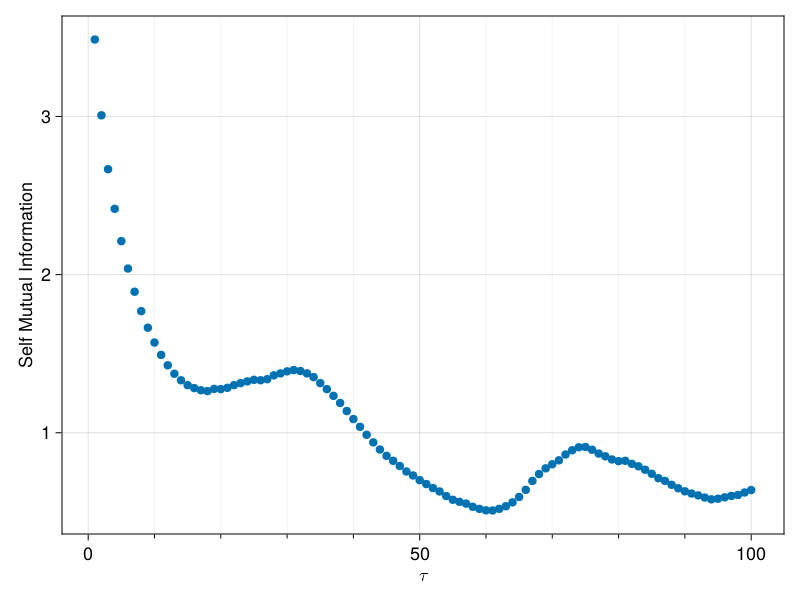

In [42]:
plot_selfmutualinfo(s, 1:100)

- It looks like the first minimum of the self mutual information occurs somewhere around $\tau = 17$, which is fairly similar to our previous estimate using exponential decay of the autocorrelation.

### 2.3. The `estimate_delay` Method

- DynamicalSystems.jl wraps all of these options in the convenient `estimate_delay` method ([docs](https://juliadynamics.github.io/DynamicalSystemsDocs.jl/delayembeddings/stable/separated/#DelayEmbeddings.estimate_delay)).

In [43]:
estimate_delay(s, "ac_min")

94

In [44]:
estimate_delay(s, "ac_zero")

┌ Warning: Did not cross 0 value, returning last `τ`.
└ @ DelayEmbeddings ~/.julia/packages/DelayEmbeddings/YHZpu/src/separated_de/estimate_delay.jl:41


100

In [45]:
estimate_delay(s, "exp_decay")

30

In [46]:
estimate_delay(s, "mi_min")

18

- As you can see, there is quite a range of estimates for $\tau$, emphasising once again the importance of taking a heuristic approach,

## 3. Choosing the Optimal Embedding Dimension <a class="dimension" id="dimension"></a>

- Given an estimate for the time delay, we can proceed to find the embedding dimension using false nearest neighbours.
<br>

- In DynamicalSystems.jl, we can do this using the `delay_fnn` method ([docs](https://juliadynamics.github.io/DynamicalSystemsDocs.jl/delayembeddings/stable/separated/#DelayEmbeddings.delay_fnn)).

In [47]:
function plot_fnn(s, delay, dims)
    fnn = delay_fnn(s, delay, dims)
    
    fig = Figure(fontsize = 18)
    ax = Axis(
        fig[1, 1], 
        xlabel = "Embedding Dimension",
        ylabel = "False Nearest Neighbours",
    )
    lines!(ax, dims, fnn)
    
    return fnn, fig
end

plot_fnn (generic function with 1 method)

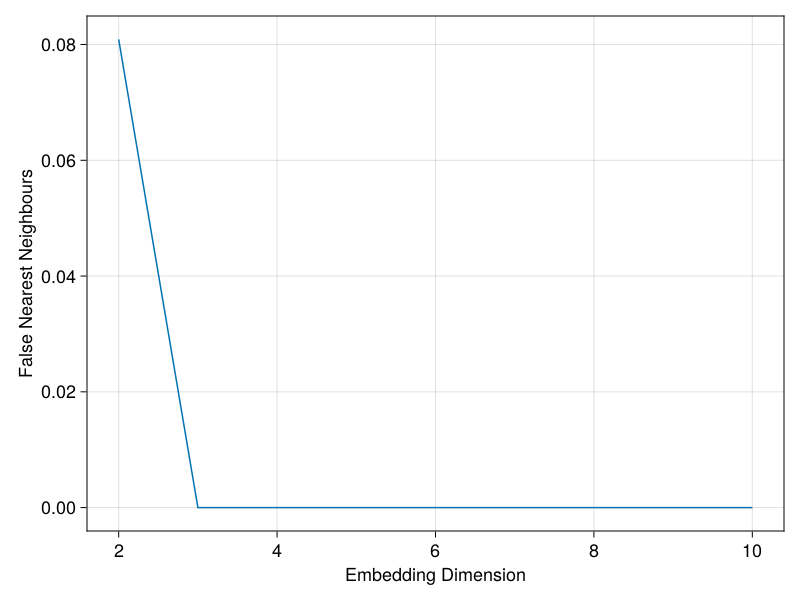

In [56]:
delay = 18
dims = 2:10
fnn, fig = plot_fnn(s, delay, dims)
fig

In [57]:
dims[findfirst(x -> x == 0, fnn)]

3

## 4. Putting It All Together <a class="anchor" id="together"></a>

- If you really do just want a quick embedding, you can fully automate the procedure outlined in the previous two sections using the method `optimal_separated_de` ([docs](https://juliadynamics.github.io/DynamicalSystemsDocs.jl/delayembeddings/stable/separated/#DelayEmbeddings.optimal_separated_de)), which returns the embedded timeseries $D$, the delay used $\tau$, and the statistic $E$ used to calculate the optimal embedding dimension.

In [58]:
D, τ, E = optimal_separated_de(s)

Algorithm stopped due to convergence of E₁-statistic. Valid embedding achieved ✓.


(3-dimensional StateSpaceSet{Float64} with 9965 points, 18, [0.00031356904612676325, 0.2302561112603625, 0.9082650807374193, 0.9187751159809299, 0.9532138107914392, 0.9650304544486566, 0.9839642165411525, 0.993133987400279, 0.9961659206458301, 0.9918679898249945])

- Here, "traditional" means that the algorithm first estimates $\tau$, and then, with $\tau$ fixed, finds the optimal embedding dimension.
<br>

- DynamicalSystems.jl also contains modern "unified" algorithms, which are more sophisticated and jointly optimise the delay and the embedding dimension. See the [docs](https://juliadynamics.github.io/DynamicalSystemsDocs.jl/delayembeddings/stable/unified/) for more details.
<br>

- Given the computational resources we have at our disposal, yet another option is to optimise the embedding with respect to the specific task at hand. For example, if we wish to make timeseries predictions, we could choose the embedding which leads to the most accurate predictions on some validation dataset. 

## 5. Lyapunov Exponents <a class="anchor" id="lyapunov"></a>

- As you know by now, the maximum Lyapunov exponent of a chaotic system measures the exponential divergence of initially infinitesimally close trajectories,

$$|\delta (t)| \approx e^{\lambda t}|\delta (0)|.$$


- Taking the log of both sides and letting $E(t) = \ln|\delta (t)|$,

$$E(t) \approx \lambda \times t + E(0).$$


- Now assume that the timeseries is sampled at equal intervals $\Delta t$ and therefore discretise time by letting $t = k \times Δt$, where $k = 0, 1, 2, \ldots$, such that

$$E(k) \approx \lambda \times k \times Δt + E(0).$$


- Given some dataset, we can now estimate the maximum Lyapunov exponent as the slope of the plot of $E(k)$ versus $k \times Δt$.
<br>

- We can estimate $E(k)$ from the data as follows:

    1. Define neighbourhoods within the data consisting of trajectories which are initially close together (e.g. using nearest neighbours).  

    2. Given those neighbourhoods, step the system forward $k$ steps and take the average of $E(k) = \ln|\delta (k)|$ over all neighbourhoods.  <br><br>
    

- DynamicalSystems.jl makes this easy by providing the methods `lyapunov_from_data` and `linear_region`.

In [59]:
# Generate a longer timeseries than we used before
tr = trajectory(ds, 1000.0; Ttr = 100.0, Δt)[1]
# s = sin.(tr[:, 1])  # Try this for a more challenging observation
s = h(tr);

In [60]:
# Estimate the optimal embedding
D, τ, E = optimal_separated_de(s)

Algorithm stopped due to convergence of E₁-statistic. Valid embedding achieved ✓.


(3-dimensional StateSpaceSet{Float64} with 99967 points, 17, [2.3251043148538583e-5, 0.09989935717411288, 0.9063839323407431, 0.9334230836407865, 0.9573973497425675, 0.9654136710123135, 0.9834096274361502, 0.9883309992400374, 0.9923985198153661, 0.990357207238376])

┌ Warning: Found linear region spans less than a 3rd of the available x-axis and might imply inaccurate slope or insufficient data. Recommended: plot `x` vs `y`.
└ @ FractalDimensions ~/.julia/packages/FractalDimensions/O7LoE/src/linear_fits/linear_regions.jl:142
┌ Warning: Found linear region spans less than a 3rd of the available x-axis and might imply inaccurate slope or insufficient data. Recommended: plot `x` vs `y`.
└ @ FractalDimensions ~/.julia/packages/FractalDimensions/O7LoE/src/linear_fits/linear_regions.jl:142
┌ Warning: Found linear region spans less than a 3rd of the available x-axis and might imply inaccurate slope or insufficient data. Recommended: plot `x` vs `y`.
└ @ FractalDimensions ~/.julia/packages/FractalDimensions/O7LoE/src/linear_fits/linear_regions.jl:142
┌ Warning: Found linear region spans less than a 3rd of the available x-axis and might imply inaccurate slope or insufficient data. Recommended: plot `x` vs `y`.
└ @ FractalDimensions ~/.julia/packages/Fracta

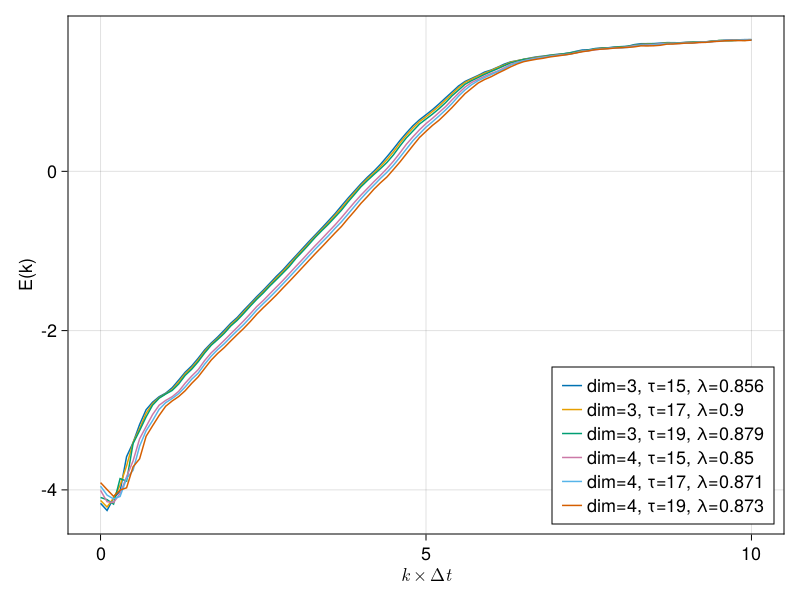

In [61]:
k_values = 0:10:1000  # Integer timesteps k * Δt

fig = Figure(figsize = (500, 500), fontsize = 18)
ax = Axis(fig[1, 1], xlabel = L"k \times Δt", ylabel="E(k)")

for dim in [3, 4], τ in [15, 17, 19]  # Try different embedding dimensions and time delays
    data_embedded = embed(s, dim, τ)
    E = lyapunov_from_data(data_embedded, k_values)  # Returns [E(k) for k ∈ k_values]
    λ = linear_region(k_values .* Δt, E)[2]          # Returns the slope of the linear region, i.e. the Lyapunov exponent
    lines!(
        ax, 
        k_values .* Δt, 
        E, 
        label = "dim=$(dim), τ=$(τ), λ=$(round(λ, digits = 3))",
    )
end

axislegend(ax, position = :rb)
fig

- How do these estimates compare to the true Lyapunov exponent?

In [62]:
lyapunov(ds, 10000.0, Ttr = 100)

0.905969692586861

- Our estimates for the Lyapunov exponent are not bad at all! In particular, the best estimate corresponds exactly to the optimal embedding returned by the `optimal_separated_de` algorithm.
<br>

- This is really quite impressive when we remember that we started with a one-dimensional observation of the system and relied on a fully automated identification of the optimal embedding.

## 6. Further Reading <a class="anchor" id="further-reading"></a>

1. [DynamicalSystems.jl documentation](https://juliadynamics.github.io/DynamicalSystems.jl/dev/)
2. [DelayEmbeddings.jl documentation](https://juliadynamics.github.io/DelayEmbeddings.jl/dev/)
3. [Nonlinear Time Series Analysis (Kantz & Schreiber 2003)](https://www.cambridge.org/core/books/nonlinear-time-series-analysis/519783E4E8A2C3DCD4641E42765309C7)
4. [Analysis of Observed Chaotic Data (Abarbanel 1996)](https://link.springer.com/book/10.1007/978-1-4612-0763-4)